In [11]:
#imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

from matplotlib import pyplot as plt

from utils.basic_utils import *
from utils.fundamental import chain_outlier, get_focus_tickers, best_performers
from utils.pricing import load_px_close, get_return_intervals 
from utils.pricing import dummy_col, discret_rets, sample_wgts, px_fwd_ret
from utils.pricing import px_mom_feats, px_mom_co_feats_light, px_fwd_rets, get_ind_index
from utils.pricing import eq_wgt_indices, to_index_form, rename_col

pd.options.display.float_format = '{:,.2f}'.format

import time, os, sys
from tqdm import tqdm

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, log_loss, precision_recall_fscore_support
from sklearn.metrics import precision_score, roc_auc_score

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

import numpy as np
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, Adagrad, Adadelta, Adamax, Nadam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.layers import BatchNormalization

In [12]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### Context data

In [ ]:
# get latest pricing file from inferece server
px_close_ds = context['px_close']
tmp_path = context['tmp_path']
os.makedirs(tmp_path, exist_ok=True)
!scp -i ~/.ssh/qc_infra.pem ubuntu@52.13.205.29:~/inception/tmp/{px_close_ds} {tmp_path}{px_close_ds}

In [93]:
# context
bench = '^GSPC'
y_col = 'fwdReturn'
tickers = excl(config['companies'], [])

context = {
    'ml_path': '../ML/',
    'model_name': 'micro_TF.h5',
    'tmp_path': '../tmp/',
    'ds_name': 'co-technicals-ds',
    'px_close': 'universe-px-ds',
    'trained_cols': 'micro_TF_train_cols.npy',
    'look_ahead': 120,
    'look_back': 252*5,
    'load_ds': True,
    'scale': True,
    'test_size': .05,
    'verbose': True,
    's3_path': 'recommend/micro_ML/',
    'units': 850,
    'max_iter': 50,
    'l2_reg': 0.01,
}

In [94]:
# Quotes, profile, and industries
dates = read_dates('quote')
tgt_date = dates[-1] # last date saved in S3
print(f'Target date: {tgt_date}')

equity_symbols = config['companies']

quotes = load_csvs('quote_consol', [tgt_date])
quotes = quotes.loc[quotes.symbol.isin(equity_symbols)]
quotes.set_index('symbol', drop=False, inplace=True)

profile = load_csvs('summary_detail', ['assetProfile'])
profile = profile.loc[profile.symbol.isin(equity_symbols)]
profile.set_index('symbol', drop=False, inplace=True)

Target date: 2019-05-17
Loading file quote/csv/2019-05-17
Loading file summary-categories/assetProfile


In [95]:
# load stored pricing
px_close = load_px_close(
    context['tmp_path'], context['px_close'], context['load_ds']).drop_duplicates()
print('px_close.info()', px_close.info())

fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]
clean_co_px = px_close.dropna(subset=[bench])[tickers].fillna(method='ffill')

cut_range = get_return_intervals(
    clean_co_px, 
    context['look_ahead'], 
    tresholds=[0.25, 0.75])

print(f'Return intervals {np.round(cut_range, 3)}')

<class 'pandas.core.frame.DataFrame'>
Index: 4674 entries, 2004-05-16 to 2019-05-17
Columns: 1291 entries, 0700.HK to KRW=X
dtypes: float32(1291)
memory usage: 23.1+ MB
px_close.info() None
Return intervals [  -inf -0.176 -0.107  0.14   0.252    inf]


In [96]:
# Training/inference subset
tgt_sectors = [
    'Technology',
    'Healthcare',
    'Industrials',
    'Basic Materials',
    'Consumer Cyclical',
    'Financial Services',
    'Consumer Defensive',
    'Real Estate',
    'Utilities',
    'Communication Services',
    'Energy',
]

# tickers = list(profile.loc[profile.sector.isin(tgt_sectors), 'symbol'])
tickers = list(best_performers(clean_co_px, tickers=tickers, years=10, quantile=0.75).index)

context['tickers'] = tickers
print(f'{len(tickers)} companies')

248 companies


### Final

In [97]:
def pre_process_ds(context):
    
    tickers = context['tickers']
    sectors = profile.loc[profile.symbol.isin(tickers)].sector.unique()
    industries = profile.loc[profile.symbol.isin(tickers)].industry.unique()
    print(f'Sectors: {sectors.shape[0]}, Industries: {industries.shape[0]}')
    
    indices_df = pd.concat(
        [eq_wgt_indices(profile, px_close, 'sector', sectors, subset=tickers),
        eq_wgt_indices(profile, px_close, 'industry', industries, subset=tickers),
        to_index_form(px_close[bench], bench)], 
        axis=1).drop_duplicates()
    
    # create price momentum features
    tmp_path = context['tmp_path']
    ds_name = context['ds_name']

    super_list = []
    for i, ticker in tqdm(enumerate(tickers)):
        try:
            close = px_close[ticker].dropna()
            ft_df = px_mom_feats(close, ticker, incl_name=False)
            if ticker in profile.symbol.unique():
                top_groups = tuple([bench, profile.loc[ticker, 'sector']])
                co = px_mom_co_feats_light(close, indices_df, top_groups)
                ft_df = pd.concat([ft_df, co.loc[ft_df.index, :]], axis=1)
                super_list.append(ft_df.copy())
            else: print(ticker, 'missing profile, skipping')
        except Exception as e: 
            print("Exception: {0} {1}".format(ticker, e))

    joined_df = pd.concat(super_list, axis=0)
    joined_df = chain_outlier(joined_df, None)
        
    # basic impute and scaling
    scale_on = context['scale']
    scaler = StandardScaler()
    num_cols = numeric_cols(joined_df)
#     joined_df.loc[:, num_cols] = joined_df[num_cols].replace([np.inf, -np.inf, np.nan], 0)
    joined_df.dropna(inplace=True)
    if scale_on: joined_df.loc[:, num_cols] = scaler.fit_transform(joined_df[num_cols])

    # add categoricals
    joined_df = dummy_col(joined_df, 'sector', shorten=True)
    
    return joined_df

In [98]:
def get_train_test_sets(context):
    
    verbose = context['verbose']
    ml_path, model_name = context['ml_path'], context['model_name']
    trained_cols = context['trained_cols']    
    test_size = context['test_size']    
    look_ahead = context['look_ahead']

    tickers = context['tickers']
    print(f'Training on {len(context["tickers"])} companies')

    joined_df = pre_process_ds(context)

    # calculation of forward returns
    look_ahead = context['look_ahead']
    Y = clean_co_px.apply(px_fwd_ret, args=(look_ahead, int(look_ahead/4)))
    Y = Y[~(Y.isna().all(1))]

    # reshapes to include symbol in index in additional to date
    Y_df = Y.loc[joined_df.index.unique().sortlevel()[0], tickers]
    Y_df = Y_df.stack().to_frame().rename(columns={0: y_col})
    # somwhat repetitive with steps above but performs faster
    Y_df.index.set_names(['storeDate', 'symbol'], inplace=True)
    print('Y_df.shape', Y_df.shape)

    # re-index processed df on storeDate and symbol to have similar indices
    joined_df.index.set_names('storeDate', inplace=True)
    joined_df.set_index(['symbol'], append=True, inplace=True)
    print('joined_df.shape', joined_df.shape)

    # add Y values to processed df fast without having to loop
    joined_df.loc[:, y_col] = Y_df.loc[joined_df.index, y_col]

    # joined_df.loc[(slice(None), 'AAPL'), y_col].plot() # visualize smoothing
    # joined_df.groupby('symbol')[y_col].mean().sort_values() # rank long-term mean performance

    # discretize Y-variable
    joined_df.dropna(subset=[y_col], inplace=True)
    joined_df[y_col] = discret_rets(joined_df[y_col], cut_range, fwd_ret_labels)
    print('joined_df.shape', joined_df.shape)
    print(sample_wgts(joined_df[y_col]))

    joined_df.dropna(subset=[y_col], inplace=True)
    joined_df.loc[:, y_col] = joined_df[y_col].astype(str)

    days = len(joined_df.index.levels[0].unique())
    print(f'Training for {days} dates, {round(days/252, 1)} years')

    # joined_df.loc[(slice(None), 'TAL'), y_col].value_counts() # look at a specific security distribution
    train_df = joined_df.reset_index(drop=True)
    train_df.shape

    # create training and test sets
    X, y = train_df.drop(columns=y_col), train_df[y_col]
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        break # just one split

    # skf = StratifiedKFold(n_splits=2, random_state=None)
    # for train_index, test_index in skf.split(X, y):
    #     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    #     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    #     break
          
    return X_train, X_test, y_train, y_test

In [99]:
def train_ds(context):
    
    X_train, X_test, y_train, y_test = get_train_test_sets(context)
    
    # Keras Model
    max_iter = context['max_iter']
    l2_reg = context['l2_reg']
    units = context['units']
    trained_cols = context['trained_cols']

    y_train_oh = pd.get_dummies(y_train)[fwd_ret_labels]
    y_test_oh = pd.get_dummies(y_test)[fwd_ret_labels]

    model = Sequential()
    model.add(Dense(units, activation='relu', input_dim=X_train.shape[1]))
    # model.add(Dropout(0.05))
    model.add(Dense(units, activation='relu'))
    model.add(Dense(units, activation='relu'))
    model.add(Dense(units, activation='relu'))
    model.add(Dense(int(units/2), activation='relu'))
    model.add(Dense(len(pd.unique(y_train)), activation='softmax'))
    keras.regularizers.l2(l2_reg)

    opt = Adam()
    # opt = Nadam() #essentially RMSprop with momentum, Nadam is Adam RMSprop with Nesterov momentum
    # opt = RMSprop() #optimizer is usually a good choice for recurrent neural networks

    ml_path, model_name = context['ml_path'], context['model_name']
    fname = ml_path + model_name
    es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=1)
    checkpointer = ModelCheckpoint(filepath=fname, verbose=1, save_best_only=True)
    csv_logger = CSVLogger('micro-train.log')

    # save training columns
    np.save(ml_path + trained_cols, X_train.columns) # save feature order
    print(f'X_train.shape {X_train.shape}, columns: {list(X_train.columns)}')
    print('Saved: ', ml_path + trained_cols)    
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    history = model.fit(X_train, y_train_oh, validation_data=(X_test, y_test_oh), 
              epochs=max_iter, batch_size=200, callbacks=[es, checkpointer, csv_logger])

    score = model.evaluate(X_test, y_test_oh)
    print(f'Test loss: {score[0]}, Test accuracy: {score[1]}')

    # save model to drive
    model.save(fname)
    print('Saved ', fname)

In [100]:
def predict_ds(context):
    
    ml_path = context['ml_path']
    model_name = context['model_name']
    trained_cols = context['trained_cols']
    look_back = context['look_back']
    
    joined_df = pre_process_ds(context)
    pred_X = joined_df.loc[joined_df.sort_index().index.unique()[-look_back:], :]
    print('pred_X.shape', pred_X.shape)

    # ensure prediction dataset is consistent with trained model
    train_cols = np.load(ml_path + trained_cols, allow_pickle=True) # save feature order
    missing_cols = [x for x in train_cols if x not in pred_X.columns]
    if len(missing_cols):
        print(f'Warning missing columns: {missing_cols}')
        pred_X = pd.concat([pred_X, pd.DataFrame(columns=missing_cols)], axis=1)
        pred_X[missing_cols] = 0

    sorted_cols = list(np.append(train_cols, ['symbol']))
    print('pred_X.shape', pred_X[sorted_cols].shape)

    pred_df = pd.DataFrame()
    pred_df['symbol'] = pred_X.symbol

    # Load model    
    fname = ml_path + model_name
    model = load_model(fname)
    print('Loaded', fname)

    preds = model.predict(pred_X[sorted_cols].iloc[:, :-1])
    preds_classes = model.predict_classes(pred_X[sorted_cols].iloc[:, :-1])    

    pred_df['pred_class'] = preds_classes
    pred_df['pred_label'] = list(map(lambda x: fwd_ret_labels[x], preds_classes))
    probs = np.round(preds,3)
    pred_prob = np.argmax(probs, axis=1)
    pred_df['confidence'] = [x[np.argmax(x)] for x in probs] # higest prob
    prob_df = pd.DataFrame(probs, index=pred_df.index, columns=fwd_ret_labels)
    pred_df = pd.concat([pred_df, prob_df[fwd_ret_labels]], axis=1)
    pred_df.index.name = 'pred_date'    
    
    # store in S3
    s3_path = context['s3_path']
    s3_df = pred_df.reset_index(drop=False)
    rename_col(s3_df, 'index', 'pred_date')
    csv_store(s3_df, s3_path, csv_ext.format(tgt_date))
            
    return pred_df

#### Train

In [34]:
max_iter = context['max_iter']
l2_reg = context['l2_reg']
units = context['units']
trained_cols = context['trained_cols']

X_train, X_test, y_train, y_test = get_train_test_sets(context)

y_train_oh = pd.get_dummies(y_train)[fwd_ret_labels]
y_test_oh = pd.get_dummies(y_test)[fwd_ret_labels]

Training on 248 companies
Sectors: 11, Industries: 83


32it [00:03,  9.69it/s]

REGN missing profile, skipping


51it [00:05,  9.91it/s]

ULTI missing profile, skipping


73it [00:08,  9.83it/s]

JBT missing profile, skipping


94it [00:10,  9.73it/s]

ABMD missing profile, skipping


131it [00:14,  9.93it/s]

ROP missing profile, skipping


161it [00:18,  9.82it/s]

9984.T missing profile, skipping


192it [00:21,  9.00it/s]

LRCX missing profile, skipping


233it [00:26,  9.93it/s]

ODFL missing profile, skipping


248it [00:28,  8.64it/s]
/home/ubuntu/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Y_df.shape (828438, 1)
joined_df.shape (823329, 28)


/home/ubuntu/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:969: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


joined_df.shape (790857, 29)
neutral   0.44
bull      0.21
long      0.19
bear      0.11
short     0.06
Name: fwdReturn, dtype: float64
Training for 3606 dates, 14.3 years


In [ ]:
# Keras Model
model = Sequential()
model.add(Dense(units, input_dim=X_train.shape[1], use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(units, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(units, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(int(units/2), use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dense(len(pd.unique(y_train)), activation='softmax'))
keras.regularizers.l2(l2_reg)

opt = Adam()

ml_path, model_name = context['ml_path'], context['model_name']
fname = ml_path + model_name

es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=1)
checkpointer = ModelCheckpoint(filepath=fname, verbose=1, save_best_only=True)
csv_logger = CSVLogger('micro-train.log')

# save training columns
np.save(ml_path + trained_cols, X_train.columns) # save feature order
print(f'X_train.shape {X_train.shape}, columns: {list(X_train.columns)}')
print('Saved: ', ml_path + trained_cols)    

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(X_train, y_train_oh, validation_data=(X_test, y_test_oh), 
          epochs=max_iter, batch_size=64, callbacks=[es, checkpointer, csv_logger])

score = model.evaluate(X_test, y_test_oh)
print(f'Test loss: {score[0]}, Test accuracy: {score[1]}')

X_train.shape (751314, 28), columns: ['PctChg1Stds', 'PctMA50', 'PctMA200', 'RollVol30', 'PctChg20', 'PctChg60', 'PctChg120', 'Pct52WkH', 'Pct52WkL', 'rsBench20', 'rsSect20', 'rsBench60', 'rsSect60', 'rsBench120', 'rsSect120', 'benchPctChgStds', 'sectPctChgStds', '^BASI_MATE', '^COMM_SERV', '^CONS_CYCL', '^CONS_DEFE', '^ENER', '^FINA_SERV', '^HEAL', '^INDU', '^REAL_ESTA', '^TECH', '^UTIL']
Saved:  ../ML/micro_TF_train_cols.npy
Train on 751314 samples, validate on 39543 samples
Epoch 1/50
751314/751314 [==============================] - 159s 212us/step - loss: 1.3020 - acc: 0.4781 - val_loss: 1.2289 - val_acc: 0.5020

Epoch 00001: val_loss improved from inf to 1.22894, saving model to ../ML/micro_TF.h5
Epoch 2/50
751314/751314 [==============================] - 158s 211us/step - loss: 1.2022 - acc: 0.5144 - val_loss: 1.1197 - val_acc: 0.5467

Epoch 00002: val_loss improved from 1.22894 to 1.11969, saving model to ../ML/micro_TF.h5
Epoch 3/50
751314/751314 [==============================

In [ ]:
%time train_ds(context)

#### Predict

In [101]:
# predict for all
%time pred_df = predict_ds(context)

Sectors: 11, Industries: 83


3it [00:00, 10.52it/s]

ULTI missing profile, skipping


19it [00:01,  9.78it/s]

REGN missing profile, skipping


50it [00:05,  8.98it/s]/home/ubuntu/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
72it [00:08, 10.19it/s]

JBT missing profile, skipping


93it [00:10, 10.19it/s]

9984.T missing profile, skipping


106it [00:11, 10.34it/s]

ROP missing profile, skipping


184it [00:20, 10.36it/s]

LRCX missing profile, skipping
ODFL missing profile, skipping


198it [00:22, 10.22it/s]

ABMD missing profile, skipping


248it [00:27,  8.87it/s]


pred_X.shape (294891, 29)
pred_X.shape (294891, 29)
Loaded ../ML/micro_TF.h5
Saved recommend/micro_ML/2019-05-17.csv
CPU times: user 1min 29s, sys: 8.32 s, total: 1min 37s
Wall time: 1min 17s


#### Store / Read S3

In [15]:
s3_path = context['s3_path']

In [16]:
# read from S3
pred_df = pd.read_csv(
    csv_load(f'{s3_path}{tgt_date}'), 
    index_col='pred_date', parse_dates=True)

#### Visualize

In [102]:
# recommendation distribution
print('Prediction distribution')
pd.value_counts(pred_df.pred_label) / pd.value_counts(pred_df.pred_label).sum()

Prediction distribution


neutral   0.48
long      0.21
bull      0.17
bear      0.07
short     0.06
Name: pred_label, dtype: float64

/home/ubuntu/miniconda3/envs/inception/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if sys.path[0] == '':
/home/ubuntu/miniconda3/envs/inception/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  from ipykernel import kernelapp as app


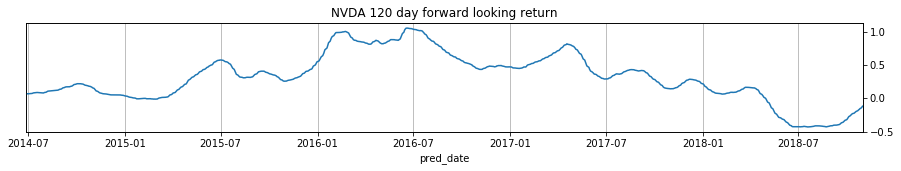

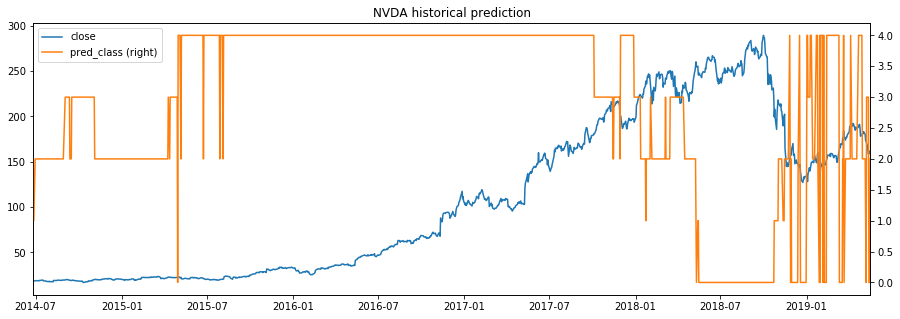

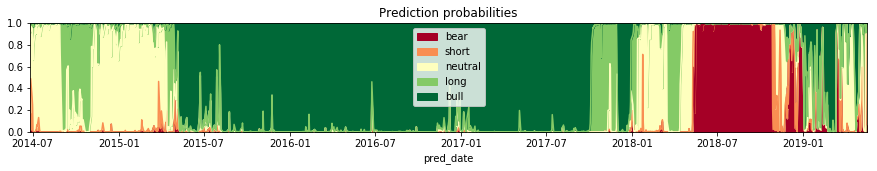

In [129]:
def plot_symbol_hist_pred(pred_symbol, clean_co_px, context, pred_df):
    
    # pred_symbol = random.choice(joined_df.symbol.unique())
    pred_symbol = pred_symbol if pred_symbol is not None else random.choice(joined_df.symbol.unique())
    px_df = clean_co_px[pred_symbol]
    px_df.name = 'close'
    look_ahead = context['look_ahead']
    pct_chg_df = px_fwd_ret(px_df, look_ahead, int(look_ahead/4))
    pct_chg_df.name = 'pct_chg'

    co_pred = pred_df.loc[pred_df.symbol.isin([pred_symbol]), ['pred_class'] + fwd_ret_labels]
    hist_pred = pd.concat([px_df.loc[pred_df.index.unique()], co_pred['pred_class']], axis=1, sort=False)

    # forward looking returns
    pct_chg_df.loc[pred_df.index.unique()].dropna().plot(
        title=f'{pred_symbol} {int(np.mean(context["look_ahead"]))} day forward looking return', 
        figsize=(15, 2), grid=True, secondary_y='pct_chg')

    # historical predictions
    hist_pred.dropna().plot(
        title=f'{pred_symbol} historical prediction', 
        figsize=(15, 5), secondary_y='pred_class')

    # probability distribution
    co_pred[fwd_ret_labels].plot.area(
        title='Prediction probabilities', 
        figsize=(15, 2), ylim=(0, 1), cmap='RdYlGn', rot=0)
    
plot_symbol_hist_pred('NVDA', clean_co_px, context, pred_df)

### Other experiments

#### Visualize forward looking returns

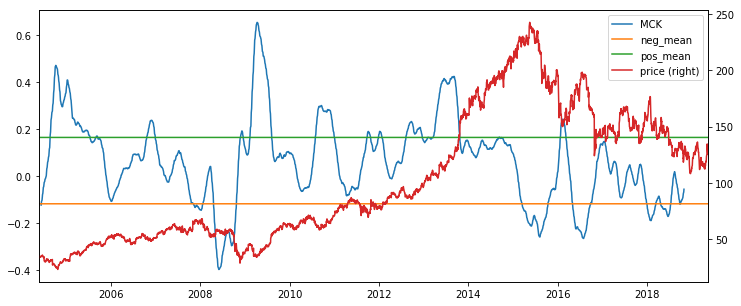

In [103]:
"""
An approach to forward looking returns, 
is it one period, an average of multiple periods, more recent, less recent?
"""
look_ahead = 120; smooth = int(look_ahead/4); s = 'MCK'
df = pd.DataFrame(px_fwd_ret(clean_co_px[s], look_ahead, smooth))
df['neg_mean'] = df[s].loc[df[s]<0].mean()
df['pos_mean'] = df[s].loc[df[s]>0].mean()
df['price'] = clean_co_px[s]
df.plot(figsize=(12,5), secondary_y='price')

In [12]:
# try with full universe
look_ahead = context['look_ahead']
Y = clean_co_px.apply(px_fwd_ret, args=(look_ahead, int(look_ahead/4)))
Y = Y[~(Y.isna().all(1))]

In [ ]:
Y.describe().T.sort_values(by='max')

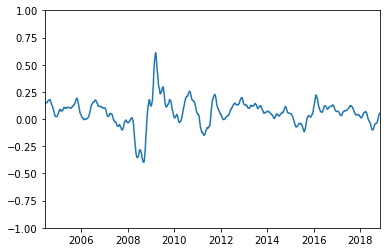

In [15]:
Y.iloc[:, :].dropna(axis=1).mean(axis=1).plot(ylim=(-1, 1), legend=False)

#### Train universe on long-term winners

In [282]:
hist_return = best_performers(clean_co_px, tickers, years=10, quantile=0.75)
print(f'{len(hist_return.index)} companies')
desc_df = pd.concat([
    profile.loc[hist_return.index, ['sector', 'industry', 'country',]],
    quotes.loc[hist_return.index, ['shortName', 'marketCap']]], axis=1)
desc_df.loc[:, 'marketCap'] = desc_df.marketCap / 10**9
desc_df.loc[:, 'size'] = discret_rets(desc_df.marketCap, mkt_cap_cuts, mkt_cap_labels)

hist_return = pd.concat([hist_return, desc_df], axis=1, sort=False)

236 companies


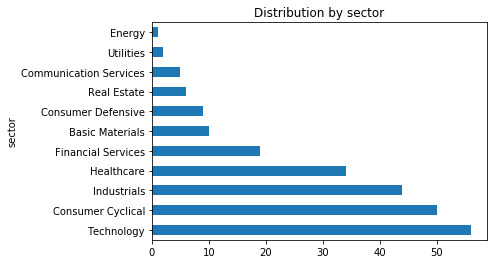

industry
Software - Application            15
Business Services                 10
Semiconductors                     9
Diversified Industrials            9
Medical Instruments & Supplies     8
Diagnostics & Research             8
Internet Content & Information     7
Health Care Plans                  7
Biotechnology                      6
Airlines                           6
Name: sector, dtype: int64

In [283]:
by_sect = desc_df.groupby(by=['sector']).count().iloc[:,0].sort_values(ascending=False)
by_sect.plot.barh(title='Distribution by sector');
plt.show()

by_ind = desc_df.groupby(by=['industry']).count().iloc[:,0].sort_values(ascending=False)
by_ind.head(10)

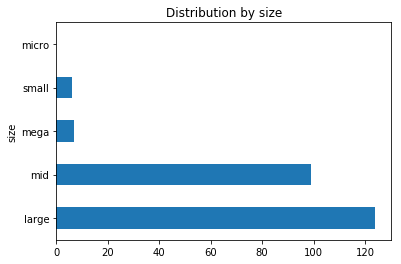

In [284]:
desc_df.groupby(by=['size']).count().iloc[:,0].sort_values(ascending=False).plot.barh(title='Distribution by size');

In [293]:
group_winners = hist_return.groupby(by=['sector']).agg(['count', 'mean'])
group_winners[['totalReturn', 'marketCap']]\
    .sort_values(by=('totalReturn','mean'), ascending=False)\
    .dropna()

totalReturn       marketCap       
                             count  mean     count   mean
sector                                                   
Technology                      56 16.06        56 145.70
Consumer Cyclical               50 10.81        50  50.10
Communication Services           5 10.44         5  63.25
Healthcare                      34  9.22        34  29.54
Industrials                     44  8.51        44  25.06
Basic Materials                 10  8.44        10   6.81
Consumer Defensive               9  8.22         9  25.25
Financial Services              19  7.75        19  49.33
Real Estate                      6  7.53         6  22.73
Utilities                        2  5.47         2  15.39
Energy                           1  5.14         1  25.98

In [316]:
group_winners = hist_return.groupby(by=['sector', 'industry', 'shortName']).agg(['count', 'mean'])
group_winners[['totalReturn', 'marketCap']]\
    .sort_values(by=('totalReturn','mean'), ascending=False)\
    .dropna().head(20)

totalReturn  \
                                                                                                 count   
sector                 industry                            shortName                                     
Technology             Software - Infrastructure           CyberArk Software Ltd.                    1   
Consumer Cyclical      Media - Diversified                 Netflix, Inc.                             1   
                       Specialty Retail                    Ulta Beauty, Inc.                         1   
                       Restaurants                         Domino's Pizza Inc                        1   
Healthcare             Diagnostics & Research              DexCom, Inc.                              1   
Consumer Cyclical      Apparel Stores                      lululemon athletica inc.                  1   
Healthcare             Medical Devices                     Align Technology, Inc.                    1   
Financial Services     Capital Markets                     MarketAxess Holdings, Inc.                1   
Healthcare             Biotechnology                       Incyte Corporation                        1   
Communication Services Telecom Services                    Vonage Holdings Corp.                     1   
Industrials            Rental & Leasing Services           United Rentals, Inc.                      1   
Consumer Cyclical      Specialty Retail                    Amazon.com, Inc.                          1   
Technology             Internet Content & Information      TENCENT                                   1   
Consumer Cyclical      Specialty Retail                    MercadoLibre, Inc.                        1   
Basic Materials        Building Materials                  Trex Company, Inc.                        1   
Technology             Semiconductor Equipment & Materials Universal Display Corporation             1   
                       Semiconductors                      NVIDIA Corporation                        1   
                       Software - Infrastructure           Fair Isaac Corproation                    1   
Consumer Cyclical      Leisure                             Booking Holdings Inc. Common St           1   
Consumer Defensive     Beverages - Wineries & Distilleries Constellation Brands, Inc.                1   

                                                                                                   \
                                                                                             mean   
sector                 industry                            shortName                                
Technology             Software - Infrastructure           CyberArk Software Ltd.          428.37   
Consumer Cyclical      Media - Diversified                 Netflix, Inc.                    64.90   
                       Specialty Retail                    Ulta Beauty, Inc.                39.96   
                       Restaurants                         Domino's Pizza Inc               33.55   
Healthcare             Diagnostics & Research              DexCom, Inc.                     30.73   
Consumer Cyclical      Apparel Stores                      lululemon athletica inc.         28.37   
Healthcare             Medical Devices                     Align Technology, Inc.           27.80   
Financial Services     Capital Markets                     MarketAxess Holdings, Inc.       26.88   
Healthcare             Biotechnology                       Incyte Corporation               26.77   
Communication Services Telecom Services                    Vonage Holdings Corp.            24.60   
Industrials            Rental & Leasing Services           United Rentals, Inc.             24.22   
Consumer Cyclical      Specialty Retail                    Amazon.com, Inc.                 24.19   
Technology             Internet Content & Information      TENCENT                          23.44   
Consumer Cyclical      Specialty Ret

In [324]:
group_winners = hist_return.groupby(by=['sector', 'industry']).agg(['count', 'mean'])
group_winners[['totalReturn', 'marketCap']]\
    .sort_values(by=('totalReturn','mean'), ascending=False)\
    .dropna().head(20)

totalReturn         \
                                                                 count   mean   
sector                 industry                                                 
Technology             Software - Infrastructure                     3 150.42   
Healthcare             Medical Devices                               1  27.80   
Consumer Cyclical      Media - Diversified                           5  18.97   
                       Specialty Retail                              6  18.77   
Industrials            Rental & Leasing Services                     2  16.96   
Consumer Defensive     Beverages - Wineries & Distilleries           1  16.59   
Consumer Cyclical      Apparel Stores                                3  15.02   
Healthcare             Long-Term Care Facilities                     1  14.67   
Industrials            Staffing & Outsourcing Services               3  13.25   
Consumer Cyclical      Restaurants                                   5  12.64   
Technology             Electronic Gaming & Multimedia                1  12.07   
Financial Services     Capital Markets                               4  11.98   
Consumer Cyclical      Auto Parts                                    2  11.92   
Communication Services Telecom Services                              4  11.84   
Consumer Defensive     Beverages - Brewers                           1  11.50   
Technology             Semiconductor Equipment & Materials           4  11.44   
Real Estate            REIT - Industrial                             2  11.25   
Industrials            Aerospace & Defense                           5  11.12   
Consumer Cyclical      Leisure                                       4  10.81   
Basic Materials        Building Materials                            3  10.72   

                                                           marketCap         
                                                               count   mean  
sector                 industry                                              
Technology             Software - Infrastructure                   3 331.54  
Healthcare             Medical Devices                             1  25.81  
Consumer Cyclical      Media - Diversified                         5  87.17  
                       Specialty Retail                            6 172.15  
Industrials            Rental & Leasing Services                   2   6.16  
Consumer Defensive     Beverages - Wineries & Distilleries         1  38.92  
Consumer Cyclical      Apparel Stores                              3  40.89  
Healthcare             Long-Term Care Facilities                   1   3.00  
Industrials            Staffing & Outsourcing Services             3   4.03  
Consumer Cyclical      Restaurants                                 5  26.98  
Technology             Electronic Gaming & Multimedia              1  11.28  
Financial Services     Capital Markets                             4  29.43  
Consumer Cyclical      Auto Parts                                  2   2.51  
Communication Services Telecom Services                            4  29.66  
Consumer Defensive     Beverages - Brewers                         1   3.94  
Technology             Semiconductor Equipment & Materials         4   6.32  
Real Estate            REIT - Industrial                           2   9.34  
Industrials            Aerospace & Defense                         5  56.60  
Consumer Cyclical      Leisure                                     4  28.75  
Basic Materials        Building Materials                          3   2.93

In [322]:
hist_return.loc[hist_return.industry.isin(['Software - Application']), :]\
    .sort_values(by='totalReturn', ascending=False)

,totalReturn,sector,industry,country,shortName,marketCap,size
MANH,15.22,Technology,Software - Application,United States,"Manhattan Associates, Inc.",4.24,mid
CRM,14.85,Technology,Software - Application,United States,Salesforce.com Inc,119.76,large
TYL,12.68,Technology,Software - Application,United States,"Tyler Technologies, Inc.",8.19,mid
CDNS,12.25,Technology,Software - Application,United States,"Cadence Design Systems, Inc.",19.30,large
ADBE,10.12,Technology,Software - Application,United States,Adobe Inc.,136.55,large
RHT,9.53,Technology,Software - Application,United States,"Red Hat, Inc.",32.98,large
INTU,9.18,Technology,Software - Application,United States,Intuit Inc.,63.59,large
ADSK,8.42,Technology,Software - Application,United States,"Autodesk, Inc.",38.38,large
PTC,7.33,Technology,Software - Application,United States,PTC Inc.,9.99,mid
ANSS,6.20,Technology,Software - Application,United States,"ANSYS, Inc.",15.74,large


#### historical price performance analysis

Mean positive: 0.23362956941127777, Mean negative: -0.13078920543193817


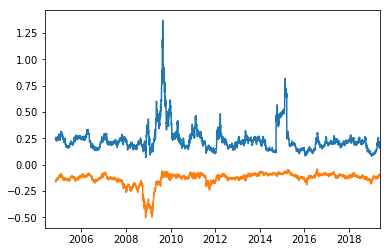

In [140]:
# Average increase and decrease over a give time period
prices = px_close.dropna(subset=[bench])[tickers]
excl_tickers = list(prices.iloc[-1].isna().loc[prices.iloc[-1].isna().values].index)
prices = prices[excl(prices.columns, excl_tickers)]

look_ahead = context['look_ahead']
pos_ret = prices.pct_change(look_ahead).where(prices.pct_change(look_ahead) > 0)
pos_ret.mean(1).plot();
neg_ret = prices.pct_change(look_ahead).where(prices.pct_change(look_ahead) < 0)
neg_ret.mean(1).plot();
print(f'Mean positive: {pos_ret.mean(1).mean()}, Mean negative: {neg_ret.mean(1).mean()}')

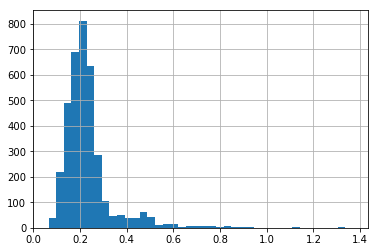

In [135]:

pos_ret.mean(1).hist(bins=40)
# pos_ret.mean(1).plot.kde(secondary_y=True)

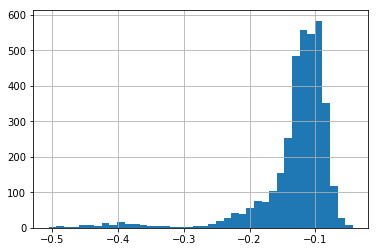

In [136]:
neg_ret.mean(1).hist(bins=40)
# neg_ret.mean(1).plot.kde(secondary_y=True)

In [550]:
# class distribution cuts
np.round(get_return_intervals(prices, 120, tresholds=[0.1, 0.5]), 2)

array([ -inf, -0.23, -0.15,  0.14,  0.22,   inf])

#### Max draws / Max pulls

Max draw: -0.09079279780791061, Max pull: 0.09960461974123547


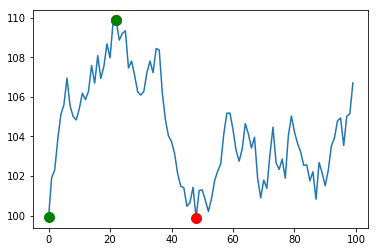

In [543]:
# Test cumulative drawdowns and pulls
from utils.pricing import max_draw_pull

n = 100
r_w = np.random.randn(n).cumsum() + 100
l_dd, h_dd, l_p, h_p = max_draw_pull(r_w)

plt.plot(r_w)
plt.plot([l_dd, h_dd], [r_w[l_dd], r_w[h_dd],], 'o', color='Red', markersize=10)
plt.plot([l_p, h_p], [r_w[l_p], r_w[h_p]], 'o', color='Green', markersize=10)

print(f'Max draw: {r_w[l_dd]/r_w[h_dd]-1}, Max pull: {r_w[h_p]/r_w[l_p]-1}')

#### Date and minute based time analysis

In [ ]:
freq = '1d'

In [ ]:
# s1, s2 = '1810.HK', 'AAPL'
group_pricing = pd.DataFrame()
df1 = get_symbol_pricing(s1, freq, ['close'])
df2 = get_symbol_pricing(s2, freq, ['close'])
group_pricing = pd.DataFrame(df1)
# group_pricing.loc[:, s2] = df2
group_pricing = pd.concat([group_pricing, df2], axis=1)
group_pricing.describe()
# group_pricing

In [ ]:
path = config['pricing_path'].format(freq)
data_dict = json_load(path + json_ext.format(ticker))

tz = data_dict['meta']['exchangeTimezoneName']
df = build_px_struct(data_dict, freq)

adjClose = data_dict['indicators']['adjclose'][0] if 'adjclose' in  data_dict['indicators'] else 0
close = data_dict['indicators']['quote'][0]
data_dict.keys(), data_dict['indicators'].keys()

In [ ]:
df.index.date

In [ ]:
dates = pd.to_datetime(
        data_dict['timestamp'], 
        unit='s', infer_datetime_format=True)
# dates = dates.astype(f'datetime64[ns, {tz}]')
# dates.tz_convert('America/New_York')
# dates = dates.tz_localize('America/New_York')
dates.floor('d' if freq == '1d' else 'min')

In [ ]:
df.tail(5)

In [ ]:
freq = '1d'

In [ ]:
%time px_close = get_mults_pricing(symbols_list[:10], freq);

In [ ]:
# [px_close[x].dropna().tail() for x in px_close.columns]
px_close.describe()
# px_close.tail()

In [ ]:
f'Ticker: {ticker}'

In [ ]:
px = get_symbol_pricing(ticker, freq)
px.close.tail()

#### Old code

In [ ]:
# test distribution of Y variable
tickers = list(mu.sample_sector_tickers(eqty_symbols, profile, sectors, 50).index)
context['grid_search'] = False
context['tickers'] = tickers
context['train_model'] = True

df_large = create_ds(context)

df = df_large.copy()
df.dropna(subset=[y_col], inplace=True)
df[y_col] = discret_rets(df[y_col], cut_range, fwd_ret_labels)
df.dropna(subset=[y_col], inplace=True) # no nas in y_col
df[y_col] = df[y_col].astype(str) # class as string
sample_wgts(df[y_col])

pred_X, X_traxin, X_test, y_train, y_test = pre_process_ds(df_large, context)
pd.value_counts(discret_rets(df_large.fwdReturn, cut_range, fwd_ret_labels)).sum()
pd.value_counts(pd.concat([y_train, y_test], axis=0)).sum()

In [ ]:
# Retrieves historical pricing
secpx = get_symbol_pricing(symbol, freq)
secpx.set_index(secpx.index.astype(np.datetime64), inplace=True)

In [ ]:
fwd_ss_ret = lambda x, df, arr: df.loc[[y for y in arr[x-1] if y in df.index.tolist()]].mean()

In [ ]:
# seasonality analysis
ss_df = closepx.pct_change().resample('M').sum().to_frame()
ss_df['year'], ss_df['month'] = ss_df.index.year, ss_df.index.month
ss_df = ss_df.pivot_table(index='year', columns='month').mean()
ss_pos = [(x, (x+1) if not (x+1) // 12 else 0, 
     x+2 if not (x+2) // 12 else x - 10) for x in range(12)]

# [fwd_ss_ret(x+1, ss_df['close'], ss_pos) for x in range(12)] # test

In [ ]:
# apply seasonality, mean return of curr month plus next two
secpx['month'] = secpx.index.month
secpx['fwdSSRet'] = secpx.loc[:].month.apply(
    fwd_ss_ret, args=(ss_df['close'], ss_pos,))

In [ ]:
secpx.columns # all columns

In [ ]:
# normalized columns for ML training, still has outliers
ml_ds_cols = secpx.describe().loc['50%'][secpx.describe().loc['50%'] < 5].index.tolist()
ml_ds_cols

In [ ]:
# prepare ML dataset
ml_ds = secpx[ml_ds_cols].copy()

class_cols = ['fwdChg1w', 'fwdChg1m', 'fwdChg3m']
cut_range = [-1, -0.05, .0, .02, .09, 1.]
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]

for c in class_cols: ml_ds[c] = pd.cut(secpx[c], cut_range, labels=fwd_ret_labels)
ml_ds.info()

In [ ]:
# drop the predicting class with most nas
ml_ds.dropna(inplace=True)
ml_ds.info()

In [ ]:
ml_ds.hist(figsize=(15,15));

In [ ]:
ml_ds.to_csv(csv_ext.format('co_price_mom_ds'), index=False)